In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import sys
sys.path
sys.path.append('/home/jovyan/test_surge_models/surgeNN')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from surgeNN.io import load_predictand,load_predictors
import matplotlib.pyplot as plt

In [2]:
#setttings
predictor_path  = 'gs://leap-persistent/timh37/era5_predictors/'
tg        = 'den_helder-denhdr-nld-rws.csv' #site to predict
temp_freq = 3 #hours
n_steps   = 9 #number of timesteps at and before predictand to use predictors at
n_cells   = 5 #n x n grid cells around TG
batch_size = 128

predictors = xr.open_dataset(os.path.join(os.path.join(predictor_path,str(temp_freq)+'hourly'),tg.replace('.csv','_era5Predictors_5x5.nc')),engine='zarr')
predictors['w'] = np.sqrt(predictors['u10']**2+predictors['v10']**2) #compute wind speed from x/y components
predictors = predictors.sel(time=slice('1979','2017'))
#predictands
tgs = os.listdir('/home/jovyan/test_surge_models/input/t_tide_3h_hourly_deseasoned_predictands')
tgs = [k for k in tgs if '.csv' in k]

availability = []
lons = []
lats = []
for tg in tgs:
    predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_hourly_deseasoned_predictands',tg) #open predictand csv
    predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
    predictand = predictand.reset_index()[['surge','date','lon','lat']]
    predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
    availability.append(np.sum(np.isfinite(predictand['surge']))/len(predictors.time))
 
    lons.append(predictand.lon.values[np.isfinite(predictand.lon.values)][0])
    lats.append(predictand.lat.values[np.isfinite(predictand.lat.values)][0])
     
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)

In [15]:
#define subset of tide gauges
subset = ['westkapelle-westkple-nld-rws.csv','den_helder-denhdr-nld-rws.csv','delfzijl-delfzl-nld-rws.csv', 'cuxhaven-825a-deu-uhslc.csv',  'esbjerg-esb-dnk-dmi.csv']
tgnames = ['West-Kapelle (NL)','Den Helder (NL)','Delfzijl (NL)','Cuxhaven (GER)','Esbjerg (DK)']
idx_subset = np.array([np.where(np.array(tgs)==place)[0][0] for place in subset])

'\n#-> subplots predictors around Den Helder at time itime_disp\nitime_disp = np.where(lstm_example.o.isel(i=0).sel(split=\'train\')>np.nanpercentile(lstm_example.o.isel(i=0).sel(split=\'train\'),99))[0][int(len(np.where(lstm_example.o.isel(i=0).sel(split=\'train\')>np.nanpercentile(lstm_example.o.isel(i=0).sel(split=\'train\'),99))[0])/2)]\n\nfor v,var in enumerate([\'u10\',\'v10\',\'w\',\'msl\']):\n    for i in np.arange(3):\n        gax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1+i*.075+.43*v, .75-i*.075,.25,.25),bbox_transform=ax.transAxes,axes_class=cartopy.mpl.geoaxes.GeoAxes, \n                     axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))\n        gax.coastlines(zorder=4,color=\'black\')\n        gax.scatter(np.array(lons)[idx_subset[4]],np.array(lats)[idx_subset[4]],facecolor=\'black\',transform=ccrs.PlateCarree(),zorder=5)\n        gax.text(np.array(lons)[idx_subset[4]]+.45,np.array(lats)[idx_subset[4]]-.65,\'5.\',transform=ccrs.PlateCarree

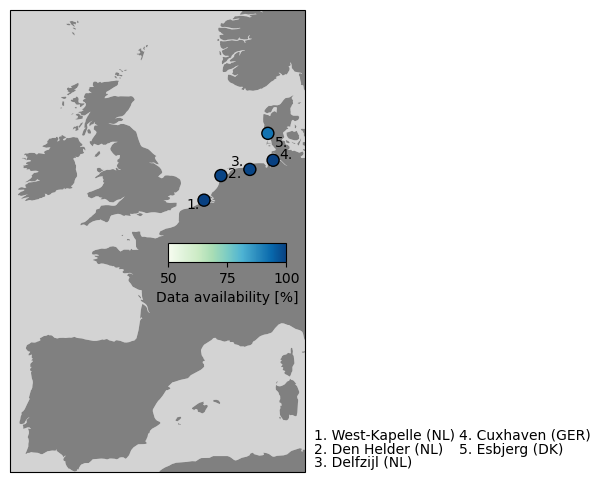

In [18]:
dx = [-1.3,.5,-1.4,.45,.45,-1.1,-1.3,.5,.5] #for plotting numbering
dy = [-.5,-.15,.2,.1,-.8,-.6,-.5,.1,-.4]

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

#-> subplot data availability
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

ax.scatter(np.array(lons)[idx_subset],np.array(lats)[idx_subset],c=100*np.array(availability)[idx_subset],cmap='GnBu',edgecolor='black',linewidth=1,transform=ccrs.PlateCarree(),zorder=10,s=75,vmin=50,vmax=100) #edge of selected locations
for i in np.arange(len(idx_subset)): #annotate locations & make legend
    ax.text(np.array(lons)[idx_subset[i]]+dx[i],np.array(lats)[idx_subset[i]]+dy[i],str(i+1)+'.',transform=ccrs.PlateCarree(),zorder=10,color='black')
    if i<3:
        ax.text(1.03,.07-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')
    if ((i>=3) & (i<6)):
        ax.text(1.52,.16-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')
    if i>=6:
        ax.text(2,.25-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Data availability [%]')

